In [1]:
library(tidyverse)
library(caret)
library(MASS)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




In [2]:
DatasetPath <- "./train.csv"
mysubset <- read.csv(DatasetPath)

In [3]:
percentHoldout <- 0.2
sscount <- nrow(mysubset); trainingIndex <- sample(sscount, sscount * (1 - percentHoldout))

training <- mysubset[trainingIndex,]
holdout <- mysubset[-trainingIndex,]

In [4]:
augmentRightTurn <- function(dataset) {
    isRightTurn <- function(entry, exit) {
        rightexit <- list(
            N = c("NW", "W", "SW"),
            NW = c("W", "SW", "S"),
            W = c("SW", "S", "SE"),
            SW = c("S", "SE", "E"),
            S = c("SE", "E", "NE"),
            SE = c("E", "NE", "N"),
            E = c("NE", "N", "NW"),
            NE = c("N", "NW", "W")
        )
        exit %in% rightexit[[entry]]
    }
    vIsRightTurn <- Vectorize(isRightTurn)
    dataset %>% 
        mutate(RightTurn = vIsRightTurn(EntryHeading, ExitHeading)) %>%
        group_by(IntersectionId, EntryHeading) %>%
        summarize(RightTurnAllowed = max(RightTurn)) %>%
        inner_join(dataset)
}

In [5]:
augmented <- augmentRightTurn(training)

`summarise()` regrouping output by 'IntersectionId' (override with `.groups` argument)

Joining, by = c("IntersectionId", "EntryHeading")



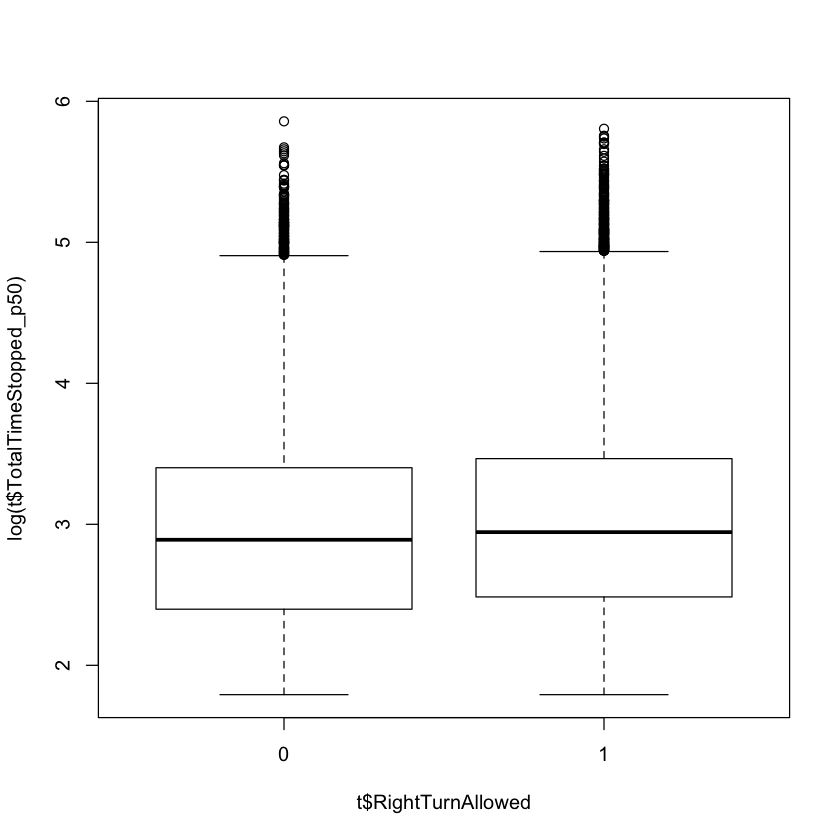

In [6]:
t <- augmented %>% filter(TotalTimeStopped_p50 > 0)
boxplot(log(t$TotalTimeStopped_p50) ~ t$RightTurnAllowed)

In [7]:
augmentLeftTurn <- function(dataset) {
    isLeftTurn <- function(entry, exit) {
        leftexit <- list(
            N = c("NE", "E", "SE"),
            NW = c("N", "NE", "E"),
            W = c("NW", "N", "NE"),
            SW = c("W", "NW", "N"),
            S = c("SW", "W", "NW"),
            SE = c("S", "SW", "W"),
            E = c("SE", "S", "SW"),
            NE = c("E", "SE", "S")
        )
        exit %in% leftexit[[entry]]
    }
    vIsLeftTurn <- Vectorize(isLeftTurn)
    dataset %>% 
        mutate(LeftTurn = vIsLeftTurn(EntryHeading, ExitHeading)) %>%
        group_by(IntersectionId, EntryHeading) %>%
        summarize(LeftTurnAllowed = max(LeftTurn)) %>%
        inner_join(dataset)
}

In [8]:
augmented <- augmentLeftTurn(augmented)

`summarise()` regrouping output by 'IntersectionId' (override with `.groups` argument)

Joining, by = c("IntersectionId", "EntryHeading")



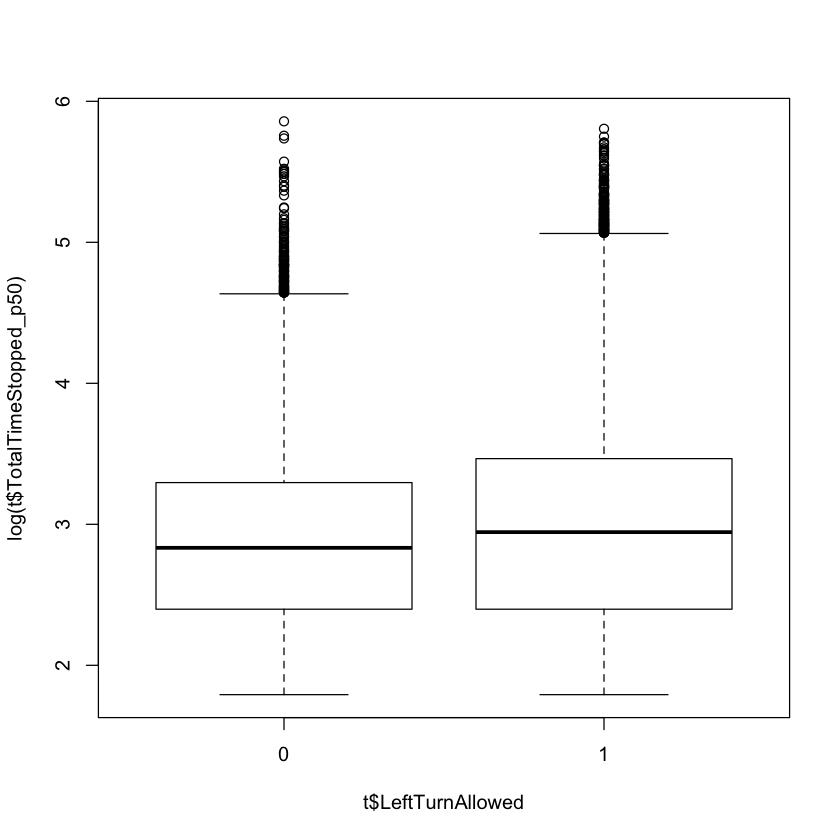

In [9]:
t <- augmented %>% filter(TotalTimeStopped_p50 > 0)
boxplot(log(t$TotalTimeStopped_p50) ~ t$LeftTurnAllowed)

In [10]:
augmented <- augmented %>% mutate(straightThrough = EntryHeading == ExitHeading)

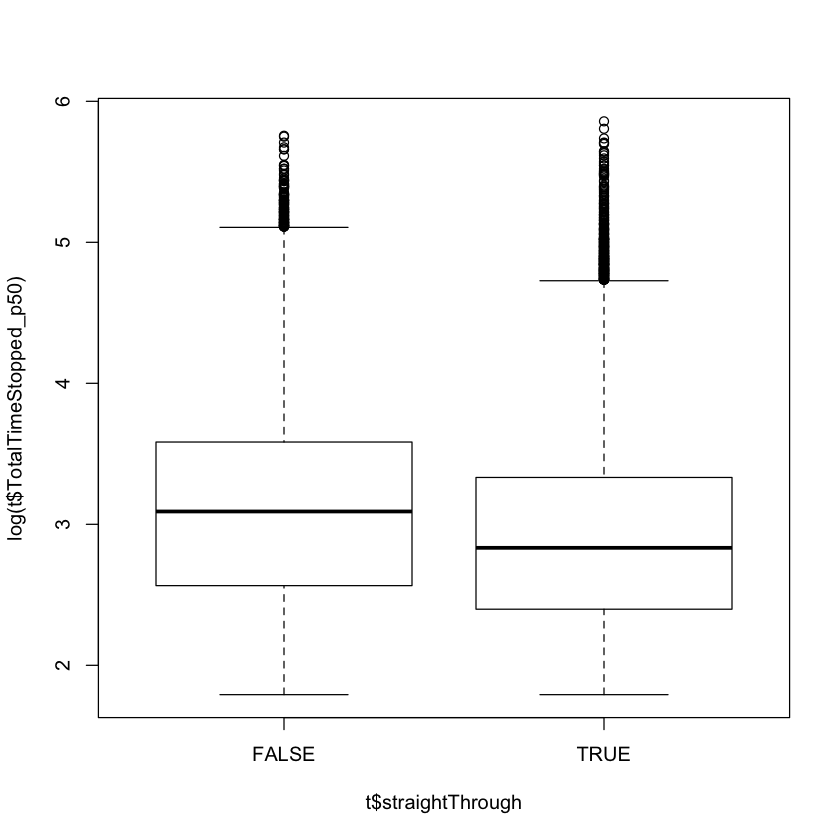

In [11]:
t <- augmented %>% filter(TotalTimeStopped_p50 > 0)
boxplot(log(t$TotalTimeStopped_p50) ~ t$straightThrough)

In [12]:
colnames(augmented)

[1] "IntersectionId"          "EntryHeading"           
 [3] "LeftTurnAllowed"         "RightTurnAllowed"       
 [5] "RowId"                   "Latitude"               
 [7] "Longitude"               "EntryStreetName"        
 [9] "ExitStreetName"          "ExitHeading"            
[11] "Hour"                    "Weekend"                
[13] "Month"                   "Path"                   
[15] "TotalTimeStopped_p20"    "TotalTimeStopped_p40"   
[17] "TotalTimeStopped_p50"    "TotalTimeStopped_p60"   
[19] "TotalTimeStopped_p80"    "TimeFromFirstStop_p20"  
[21] "TimeFromFirstStop_p40"   "TimeFromFirstStop_p50"  
[23] "TimeFromFirstStop_p60"   "TimeFromFirstStop_p80"  
[25] "DistanceToFirstStop_p20" "DistanceToFirstStop_p40"
[27] "DistanceToFirstStop_p50" "DistanceToFirstStop_p60"
[29] "DistanceToFirstStop_p80" "City"                   
[31] "straightThrough"

In [13]:
augmented <- augmented %>% mutate(waitRequired = TotalTimeStopped_p50 > 0)

In [14]:
m <- qda(waitRequired ~ City + LeftTurnAllowed + RightTurnAllowed + straightThrough + Hour + Weekend + Month, data = augmented)

In [20]:
holdout <- holdout %>% mutate(waitRequired = TotalTimeStopped_p50 > 0)
holdout <- augmentRightTurn(holdout)
holdout <- augmentLeftTurn(holdout)
holdout <- holdout %>% mutate(straightThrough = EntryHeading == ExitHeading)

`summarise()` regrouping output by 'IntersectionId' (override with `.groups` argument)

Joining, by = c("IntersectionId", "EntryHeading", "RightTurnAllowed")

`summarise()` regrouping output by 'IntersectionId' (override with `.groups` argument)

Joining, by = c("IntersectionId", "EntryHeading", "LeftTurnAllowed")



In [22]:
p <- predict(m, holdout)

In [58]:
a <- table(predictions = p$posterior[,1] < 0.5, truevalue = holdout$waitRequired)
a
a[1, 2] + a[2, 1]

           truevalue
predictions      0      1
      FALSE 102792  39548
      TRUE   14329  14609

[1] 53877

In [26]:
library(pROC)

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [31]:
holdout$waitRequired <- as.numeric(holdout$waitRequired)
holdout$waitRequired

[1] 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
   [37] 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   [73] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [109] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [145] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [181] 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [217] 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1
  [253] 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
  [289] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0
  [325] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 0
  [361] 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 1 0 1 0
  [397] 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [433] 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0
  [469] 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 0 1 0
  [505] 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
  [541] 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
  [577] 0 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  [613] 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
  [649] 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [685] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [721] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [757] 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1
  [793] 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0
  [829] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0
  [865] 1 0 0 1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 0 1 1 1 0 0 0
  [901] 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1
  [937] 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1
  [973] 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 [1009] 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 [1045] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 [1081] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 [1117] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1153] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 [1189] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 [1225] 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0
 [1261] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1297] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1333] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1369] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 [1405] 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1
 [1441] 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 [1477] 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1
 [1513] 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1
 [1549] 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1585] 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 [1621] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1657] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1
 [1693] 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 1
 [1729] 1 1 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 0
 [1765] 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 [18

In [37]:
r <- roc(holdout$waitRequired, p$posterior[,1])

Setting levels: control = 0, case = 1

Setting direction: controls > cases



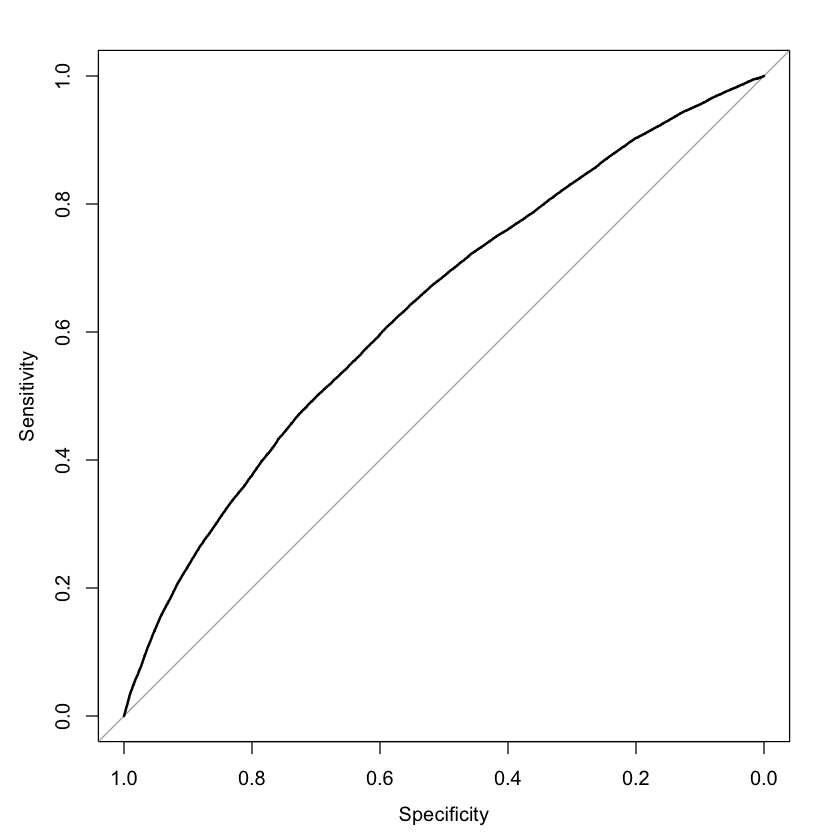

In [38]:
plot(r)